In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
# from ucimlrepo import fetch_ucirepo 

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Dataset preperation

In [3]:
class PowerConsumptionDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length
    
    def __getitem__(self, index):
        x = self.data[index:index + self.sequence_length]
        y = self.data[index + self.sequence_length, 0]  # We are predicting Global_active_power
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [29]:
file_path = 'data/household_power_consumption.txt'
data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']}, 
                   infer_datetime_format=True, low_memory=False, na_values=['?'])
data.iloc[0:20]

/tmp/ipykernel_1801/3050031756.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
/tmp/ipykernel_1801/3050031756.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
/tmp/ipykernel_1801/3050031756.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
5,2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
6,2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
7,2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0
8,2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0
9,2006-12-16 17:33:00,3.662,0.510,233.86,15.8,0.0,2.0,16.0


In [5]:
# Fill missing values
data.fillna(data.mean(), inplace=True)

# Select relevant features
selected_features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']
data_selected = data[selected_features]

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_selected.values)

In [6]:
# Create sequences
sequence_length = 60  # e.g., past 60 minutes
dataset = PowerConsumptionDataset(data_scaled, sequence_length)

# Split into train and eval sets
train_size = int(len(dataset) * 0.8)
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=256, shuffle=False)

## Model training

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(self.dropout(out[:, -1, :]))
        return out

In [8]:
# Hyperparameters
input_size = len(selected_features)  # Number of selected features
hidden_size = 50  # Reduced number of hidden units
num_layers = 2  # Reduced number of layers
output_size = 1
num_epochs = 20  # Reduced number of epochs
learning_rate = 0.001
dropout = 0.2  # Optimized dropout rate

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Directory for saving models
model_dir = './trained_models'
os.makedirs(model_dir, exist_ok=True)

In [9]:
best_eval_loss = float('inf')
for epoch in range(num_epochs):
    train_losses = []
    eval_losses = []
    
    # Training phase
    model.train()
    with tqdm(train_loader, unit="batch") as tepoch:
        for inputs, targets in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
            
            inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            tepoch.set_postfix(loss=loss.item())
            
    # Evaluation phase
    model.eval()
    with torch.no_grad():
        for inputs, targets in eval_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            eval_losses.append(loss.item())
    
    avg_train_loss = np.mean(train_losses)
    avg_eval_loss = np.mean(eval_losses)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Eval Loss: {avg_eval_loss}')
    
    # Save the best model
    if avg_eval_loss < best_eval_loss:
        best_eval_loss = avg_eval_loss
        torch.save(model.state_dict(), os.path.join(model_dir, 'best_model.pth'))

Epoch 1/20: 100%|██████████████████████████████████████| 6485/6485 [00:39<00:00, 165.52batch/s, loss=0.000404]


Epoch 1/20, Train Loss: 0.000678626248973286, Eval Loss: 0.0005489401167791748


Epoch 2/20: 100%|██████████████████████████████████████| 6485/6485 [00:39<00:00, 165.82batch/s, loss=0.000599]


Epoch 2/20, Train Loss: 0.0005942499748732372, Eval Loss: 0.0005465044808840943


Epoch 3/20: 100%|███████████████████████████████████████| 6485/6485 [00:39<00:00, 164.46batch/s, loss=0.00101]


Epoch 3/20, Train Loss: 0.00058341062501489, Eval Loss: 0.000536043476982633


Epoch 4/20: 100%|██████████████████████████████████████| 6485/6485 [00:39<00:00, 165.32batch/s, loss=0.000884]


Epoch 4/20, Train Loss: 0.0005736827296089975, Eval Loss: 0.0005264746257443178


Epoch 5/20: 100%|██████████████████████████████████████| 6485/6485 [00:39<00:00, 164.82batch/s, loss=0.000477]


Epoch 5/20, Train Loss: 0.0005585711274526093, Eval Loss: 0.0005183325206635749


Epoch 6/20: 100%|██████████████████████████████████████| 6485/6485 [00:39<00:00, 166.20batch/s, loss=0.000655]


Epoch 6/20, Train Loss: 0.0005449292818186682, Eval Loss: 0.0004989903755083367


Epoch 7/20: 100%|██████████████████████████████████████| 6485/6485 [00:39<00:00, 165.48batch/s, loss=0.000421]


Epoch 7/20, Train Loss: 0.0005321967840759635, Eval Loss: 0.000497125586683458


Epoch 8/20: 100%|██████████████████████████████████████| 6485/6485 [00:39<00:00, 165.88batch/s, loss=0.000483]


Epoch 8/20, Train Loss: 0.0005241282924566506, Eval Loss: 0.0004758136959650807


Epoch 9/20: 100%|██████████████████████████████████████| 6485/6485 [00:38<00:00, 167.18batch/s, loss=0.000335]


Epoch 9/20, Train Loss: 0.0005167227042700705, Eval Loss: 0.0004861728157535191


Epoch 10/20: 100%|█████████████████████████████████████| 6485/6485 [00:38<00:00, 166.44batch/s, loss=0.000338]


Epoch 10/20, Train Loss: 0.0005105151001058997, Eval Loss: 0.00047374366769937766


Epoch 11/20: 100%|█████████████████████████████████████| 6485/6485 [00:39<00:00, 165.95batch/s, loss=0.000349]


Epoch 11/20, Train Loss: 0.0005054079753498161, Eval Loss: 0.0004607985298907279


Epoch 12/20: 100%|█████████████████████████████████████| 6485/6485 [00:39<00:00, 165.81batch/s, loss=0.000454]


Epoch 12/20, Train Loss: 0.0004998892442176155, Eval Loss: 0.00047476656233646955


Epoch 13/20: 100%|█████████████████████████████████████| 6485/6485 [00:38<00:00, 166.66batch/s, loss=0.000568]


Epoch 13/20, Train Loss: 0.0004964102963302479, Eval Loss: 0.0004558870561380222


Epoch 14/20: 100%|█████████████████████████████████████| 6485/6485 [00:39<00:00, 164.50batch/s, loss=0.000649]


Epoch 14/20, Train Loss: 0.0004915829682886046, Eval Loss: 0.00045394822183933854


Epoch 15/20: 100%|████████████████████████████████████████| 6485/6485 [00:39<00:00, 164.82batch/s, loss=0.001]


Epoch 15/20, Train Loss: 0.00048725773634361396, Eval Loss: 0.00045949480221080697


Epoch 16/20: 100%|█████████████████████████████████████| 6485/6485 [00:38<00:00, 166.59batch/s, loss=0.000276]


Epoch 16/20, Train Loss: 0.0004832034854730609, Eval Loss: 0.00044667329883313296


Epoch 17/20: 100%|███████████████████████████████████████| 6485/6485 [00:38<00:00, 168.01batch/s, loss=0.0007]


Epoch 17/20, Train Loss: 0.00048002826238347076, Eval Loss: 0.00044133632413198326


Epoch 18/20: 100%|██████████████████████████████████████| 6485/6485 [00:39<00:00, 165.34batch/s, loss=0.00025]


Epoch 18/20, Train Loss: 0.00047583402321151004, Eval Loss: 0.000450407155844987


Epoch 19/20: 100%|█████████████████████████████████████| 6485/6485 [00:39<00:00, 165.71batch/s, loss=0.000365]


Epoch 19/20, Train Loss: 0.0004732743450017709, Eval Loss: 0.00043644503270593555


Epoch 20/20: 100%|█████████████████████████████████████| 6485/6485 [00:38<00:00, 166.64batch/s, loss=0.000476]


Epoch 20/20, Train Loss: 0.00046930976803121914, Eval Loss: 0.00043059122239553306


## Model evaluation

In [23]:
def calculate_r2_score(y_true, y_pred):
    return r2_score(y_true, y_pred)

model.load_state_dict(torch.load(os.path.join(model_dir, 'best_model.pth')))
model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for inputs, targets in eval_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())
    
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    
    r2 = r2_score(actuals, predictions)
    print(f'R² Score: {r2}')

R² Score: 0.9520396590232849


@:  torch.Size([256, 1])


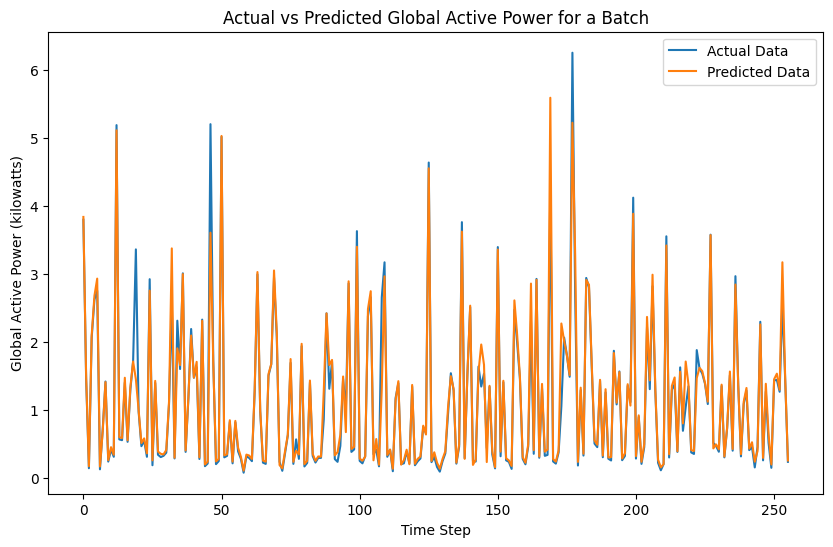

In [25]:
model.eval()
with torch.no_grad():
    # Get a single batch from the evaluation loader
    inputs, targets = next(iter(eval_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)

    print("@: ", outputs.shape)
    
    # Convert predictions and actuals to numpy arrays
    predictions = outputs.cpu().numpy()
    actuals = targets.cpu().numpy()
    
    # Inverse transform the predictions and actuals
    predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], len(selected_features) - 1))), axis=1))[:, 0]
    actuals = scaler.inverse_transform(np.concatenate((actuals.reshape(-1, 1), np.zeros((actuals.shape[0], len(selected_features) - 1))), axis=1))[:, 0]

    # Plot the actual vs predicted values for the batch
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='Actual Data')
    plt.plot(predictions, label='Predicted Data')
    plt.legend()
    plt.xlabel('Time Step')
    plt.ylabel('Global Active Power (kilowatts)')
    plt.title('Actual vs Predicted Global Active Power for a Batch')
    plt.show()